This dataset is downloaded from Kaggle.
https://www.kaggle.com/c/ml4nlp-covid19ner/overview

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c ml4nlp-covid19ner

In [ ]:
!unzip en_covid19_ner_pipeline.zip 

In [ ]:
!unzip test.pkl.zip
!unzip train.pkl.zip
!unzip val.pkl.zip
!unzip val_labels.csv.zip

!rm test.pkl.zip
!rm train.pkl.zip
!rm val.pkl.zip
!rm val_labels.csv.zip

# Load the Data

Only the Training and Validation data sets have ground truths.

In [ ]:
import keras
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
import pickle as pkl
import pandas as pd

train_dict = pkl.load(open("train.pkl", "rb"))
val_dict = pkl.load(open("val.pkl", "rb"))
test_dict = pkl.load(open("test.pkl", "rb"))
print("keys in train_dict:", train_dict.keys())
print("keys in val_dict:", val_dict.keys())
print("keys in test_dict:", test_dict.keys())

In [ ]:
# an entry of the dataset
print("index:", val_dict["id"][0])
print(*zip(val_dict["word_seq"][0], val_dict["tag_seq"][0]))

In [ ]:
print(val_dict["word_seq"][0])

# Load the spaCy model

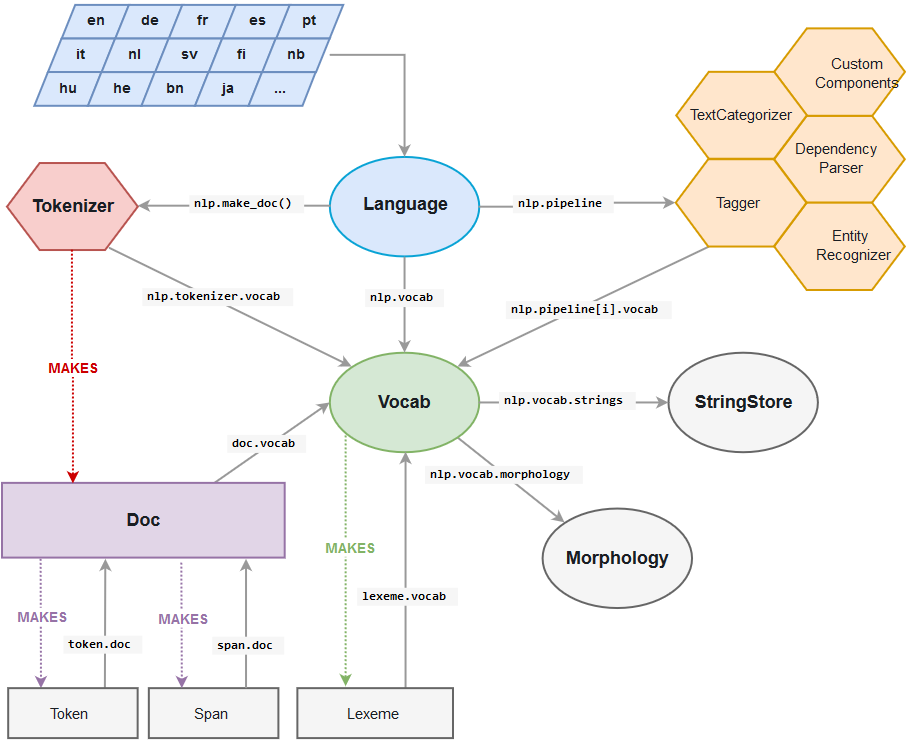

In [ ]:
import spacy

# en_core_web_sm is a small English pipeline trained on 
# written web text (blogs, news, comments), 
# that includes vocabulary, syntax and entities.
nlp = spacy.load('en_core_web_sm') 

In [ ]:
text = val_dict["word_seq"][0]
print(text)

In [ ]:
doc = nlp(" ".join(text))

for entity in doc.ents:
  print(entity.label_, ' | ', entity.text)

In [ ]:
from spacy import displacy

displacy.render(doc, style="ent", jupyter=True)

# Training a new model



1.   Initiate with blank model
2.   Create NER pipeline
3.   Add the NER pipeline to the NLP model



In [ ]:
nlp = spacy.blank('en')  # new, empty model. Let’s say it’s for the English language
nlp.vocab.vectors.name = 'example_model_training'   # give a name to our list of vectors
# add NER pipeline
ner = nlp.create_pipe('ner')  # our pipeline would just do NER
nlp.add_pipe(ner, last=True)  # we add the pipeline to the model

Structure the training data as shown below ⬇

```
DATA = [
  (u"Search Analytics: Business Value & BigData NoSQL Backend, Otis Gospodnetic ", {'entities': [ (58,75,'PERSON') ] }),
  (u"Introduction to Elasticsearch by Radu ", {'entities': [ (16,29,'TECH'), (32, 36, 'PERSON') ] }),
  # …
]
```



In [ ]:
possible_entities = set()

for i in train_dict["tag_seq"]:
  possible_entities.update(set(i))

for l in possible_entities:
  nlp.entity.add_label(l)

In [ ]:
def get(str, target_index):
  start = len(" ".join(str.split(" ")[:target_index])) + 1
  end = start + len(str.replace('.','').split(' ')[target_index])
  return (start,end)

In [ ]:
DATA = []

for j in range(len(train_dict["word_seq"])):
  text = " ".join(train_dict["word_seq"][j])
  entities=[]
  ent_dict={}
  for k in train_dict["tag_seq"][j]:
    start,end = get(text, train_dict["tag_seq"][j].index(k))
    entities.append((start,end,k))
  ent_dict['entities'] = set(entities)
  DATA.append((text, ent_dict))

Preprocess the training data and allocate optimizer.

In [ ]:
optimizer = nlp.begin_training()

In [ ]:
import random

for i in range(5):
    random.shuffle(DATA)
    for text, annotations in DATA[:1000]:
        nlp.update([text], [annotations], sgd=optimizer) # stochastic gradient descent optimizer

## Save the model

In [ ]:
nlp.to_disk("./en_covid19_ner_pipeline")

In [ ]:
!zip -r /content/en_covid19_ner_pipeline.zip /content/en_covid19_ner_pipeline

from google.colab import files
files.download('en_covid19_ner_pipeline.zip') 

# Testing the model

In [ ]:
nlp.from_disk("/content/en_covid19_ner_pipeline")

ValueError: ignored

In [ ]:
test_str = " ".join(val_dict["word_seq"][0])
print(test_str)

Immune pathways and defence mechanisms in honey bees Apis mellifera Social insects are able to mount both group-level and individual defences against pathogens . Here we focus on individual defences , by presenting a genome-wide analysis of immunity in a social insect , the honey bee Apis mellifera . We present honey bee models for each of four signalling pathways associated with immunity , identifying plausible orthologues for nearly all predicted pathway members . When compared to the sequenced Drosophila and Anopheles genomes , honey bees possess roughly one-third as many genes in 17 gene families implicated in insect immunity . We suggest that an implied reduction in immune flexibility in bees reflects either the strength of social barriers to disease , or a tendency for bees to


In [ ]:
doc = nlp(test_str)

# predicted entities
for entity in doc.ents:
  print(entity.label_, ' | ', entity.text)

ORG  |  Apis mellifera Social
LOC  |  mount
CARDINAL  |  four
GPE  |  Drosophila
CARDINAL  |  roughly one-third
CARDINAL  |  17


In [ ]:
# ground truth entities
for e in range(len(val_dict["word_seq"][0])): 
  print(val_dict["tag_seq"][0][e], ' | ', val_dict["word_seq"][0][e])

O  |  Immune
O  |  pathways
O  |  and
CHEMICAL  |  defence
CHEMICAL  |  mechanisms
O  |  in
GENE_OR_GENOME  |  honey
GENE_OR_GENOME  |  bees
GENE_OR_GENOME  |  Apis
GENE_OR_GENOME  |  mellifera
O  |  Social
O  |  insects
O  |  are
O  |  able
O  |  to
O  |  mount
O  |  both
O  |  group-level
O  |  and
O  |  individual
O  |  defences
O  |  against
O  |  pathogens
O  |  .
O  |  Here
O  |  we
O  |  focus
O  |  on
O  |  individual
O  |  defences
O  |  ,
O  |  by
O  |  presenting
O  |  a
O  |  genome-wide
O  |  analysis
O  |  of
IMMUNE_RESPONSE  |  immunity
O  |  in
O  |  a
O  |  social
CHEMICAL  |  insect
O  |  ,
O  |  the
CHEMICAL  |  honey
CHEMICAL  |  bee
CHEMICAL  |  Apis
CHEMICAL  |  mellifera
O  |  .
O  |  We
O  |  present
CHEMICAL  |  honey
CHEMICAL  |  bee
O  |  models
O  |  for
O  |  each
O  |  of
CARDINAL  |  four
CHEMICAL  |  signalling
CHEMICAL  |  pathways
O  |  associated
O  |  with
IMMUNE_RESPONSE  |  immunity
O  |  ,
O  |  identifying
O  |  plausible
O  |  orthologues
O  |  

In [ ]:
displacy.render(doc, style="ent", jupyter=True)

# Evaluation on Validation set

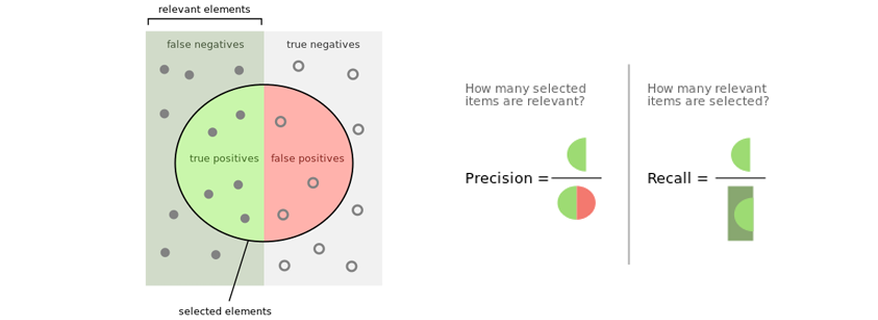

In [ ]:
VAL_DATA = []

for j in range(len(val_dict["word_seq"])):
  text = " ".join(val_dict["word_seq"][j])
  entities=[]
  for k in val_dict["tag_seq"][j]:
    start,end = get(text, val_dict["tag_seq"][j].index(k))
    entities.append((start,end,k))
  VAL_DATA.append((text, set(entities)))

In [ ]:
import spacy
from spacy.gold import GoldParse
from spacy.scorer import Scorer

def evaluate(ner_model, examples):
    scorer = Scorer()
    for input_, annot in examples:
        doc_gold_text = nlp.make_doc(input_)
        gold = GoldParse(doc_gold_text, entities=annot)
        pred_value = ner_model(input_)
        scorer.score(pred_value, gold)
    return scorer.scores

results = evaluate(nlp, VAL_DATA)

In [ ]:
print("Overall Scores:")
print("F1-score =", results['ents_f']) 
print("Precision =", results['ents_p'])
print("Recall =", results['ents_r'])

Overall Scores:
F1-score = 57.927170868347346
Precision = 69.95940460081191
Recall = 49.4263862332696
